# Fundamentos de Machine Learning - Trabalho Final

## 1. Apresentação

### Resumo
Este documento tem o objetivo de apresentar uma comparação entre métodos de aprendizagem de máquina como forma de obter nota no trabalho final do módulo de Fundamentos de Machine Learning.

### Autores
Alunos de pós-graduação em Ciência de Dados da Universidade do Estado do Amazonas:
1.   [Patrick Tapajós Pinto](https://www.linkedin.com/in/patrick-tapajos-pinto/)
2.   [Wladimir Barroso Guedes de Araújo Neto](https://www.linkedin.com/in/wladneto/)

### Ferramentas Utilizadas
A análise foi efetuada utilizando-se a linguagem de programação **Python** e suas bibliotecas para análise e processamento de dados **Pandas** e **NumPy**, bem como as bibliotecas **Matplotlib** e **Seaborn** para visualização de dados, além de API´s e outras bibliotecas que serão apresentadas no dercorrer do documento.

## 2. Sobre o dataset

Este conjunto de dados de imagens foram encontrados em pesquisas efetuadas na plataforma Kaggle.

**Contexto**:<br>

Este conjunto de dados é formado por 4.242 imagens de flores, coletados via *scrapping* em sites de hospedagem de imagens como o *Flickr*, *Google Images* e *Yandex images*.
 

**Conteúdo**:<br>
As fotos são divididas em cinco classes: camomila, tulipa, rosa, girassol, dente de leão. Para cada uma delas há 800 fotos. As fotos não são de alta resolução, cerca de 320x240 pixels e não são reduzidas a um único tamanho, elas têm proporções diferentes.

**Objetivo**: <br>
O obejtivo deste conjunto de imagens é servir como subsídio para testes de modelos de aprendizagem de máquina, principalmente aqueles relacionados à classificação de imagens.

Link para download dos dados: https://www.kaggle.com/alxmamaev/flowers-recognition


## 3. Importações Necessárias

### 3.1. Bibliotecas

In [2]:
import argparse
import cv2
import kaggle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import pathlib
import tensorflow as tf

from IPython.display import Image, display
from PIL import Image as PILImage
from pathlib import Path
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### 3.2. Base de Dados

In [3]:
# Efetuando download de dados diretamente do kaggle

wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
kaggle.api.dataset_download_files('alxmamaev/flowers-recognition', path=wd+'/dataset/flowers-recognition', unzip=True)

## 4. Preparação do Dataframe com as imagens

In [4]:
image_dir = Path('dataset/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(5)

,Filepath,Label
0,dataset/flowers-recognition/flowers/daisy/1000...,daisy
1,dataset/flowers-recognition/flowers/daisy/1014...,daisy
2,dataset/flowers-recognition/flowers/daisy/1017...,daisy
3,dataset/flowers-recognition/flowers/daisy/1017...,daisy
4,dataset/flowers-recognition/flowers/daisy/1017...,daisy


## 5. Aplicando SVM ao dataset "flowers-recognition"

In [34]:
# # Activate this code to use only 100 pictures for each label
# lst = []
# for l in image_df_sample['Label'].unique():
#     lst.append(image_df_sample[image_df_sample['Label'] == l] .sample(700, random_state = 0))
# # Concatenate the DataFrames
# image_df_sample = pd.concat(lst)

In [35]:
# Informações básicas sobre o dataset
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8646 entries, 0 to 8645
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  8646 non-null   object
 1   Label     8646 non-null   object
dtypes: object(2)
memory usage: 135.2+ KB


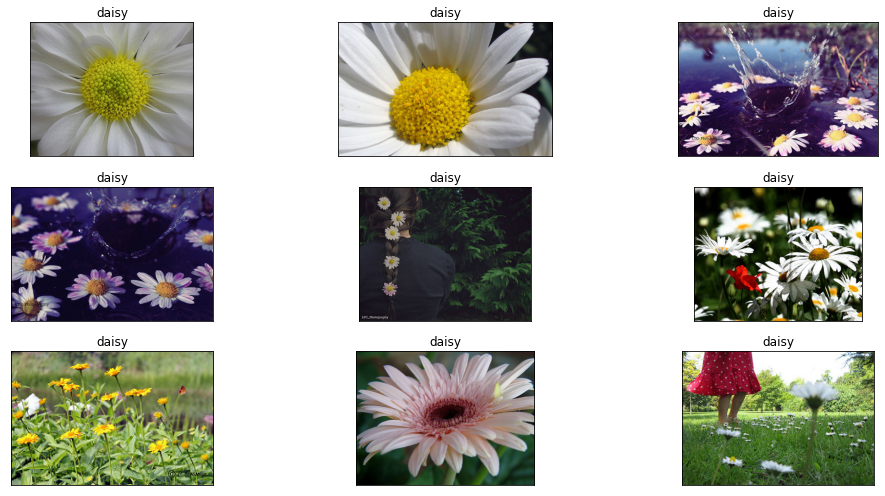

In [214]:
# Apresenta 9 exemplos de imagens do dataset

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(list(image_df['Filepath'])[i]))
    ax.set_title(list(image_df.Label)[i])
plt.tight_layout()
plt.show()

In [204]:
# Criação de 3 métodos de suporte para o treinamento do dataset.
# 1. O método get_image para ler a imagem conforme o caminho indicado
# 2. O método create_feature extrair os atributos da imagem em uma escala de cinza, necessário para o SVM
# 3. O método create_feature_matrix para criar uma matriz com as atributos extraídos de todas as imagens do dataset

IMG_SIZE = 32

def get_image(filename):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """

    img_arr = cv2.imread(filename, cv2.IMREAD_COLOR)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    
    return np.array(resized_arr)

def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    gray_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.Filepath:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix_ = np.array(features_list)
    return feature_matrix_

In [215]:
feature_matrix_svm = create_feature_matrix(image_df)

In [216]:
feature_matrix_svm.shape

(8646, 3072)

Transformação de dados com a utilização de padronização e do PCA

In [217]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix_svm.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
flower_stand = ss.fit_transform(feature_matrix_svm)

pca = PCA(n_components=1000)
# use fit_transform to run PCA on our standardized matrix
flower_pca = ss.fit_transform(flower_stand)
# look at new shape
print('PCA matrix shape is: ', flower_pca.shape)

Feature matrix shape is:  (8646, 3072)
PCA matrix shape is:  (8646, 3072)


Divisão dos dados de treino e teste

In [218]:
# Divisão dos dados de treino e teste
X = pd.DataFrame(flower_pca)
y = pd.Series(image_df.Label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

dandelion    1655
tulip        1573
daisy        1263
rose         1239
sunflower    1186
dtype: int64

Treinando o modelo

In [219]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
classifier = OneVsRestClassifier(svm)
# fit model
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=42))

Verificando a acurácia do modelo

In [220]:
# generate predictions
y_pred = classifier.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8647398843930636


In [221]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       daisy       0.81      0.83      0.82       275
   dandelion       0.86      0.89      0.88       449
        rose       0.86      0.82      0.84       329
   sunflower       0.92      0.84      0.88       282
       tulip       0.88      0.91      0.90       395

    accuracy                           0.86      1730
   macro avg       0.86      0.86      0.86      1730
weighted avg       0.87      0.86      0.86      1730



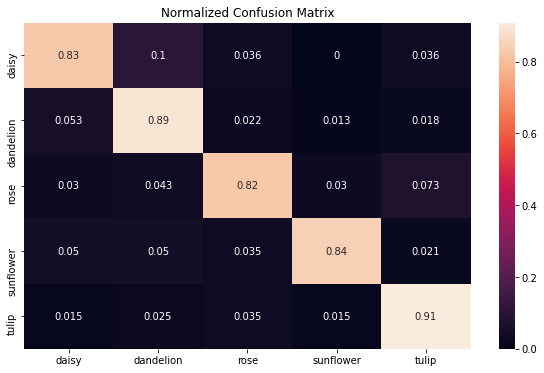

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## 3. Aplicando KNN ao dataset "flowers-recognition"

In [36]:
image_df_sample = image_df

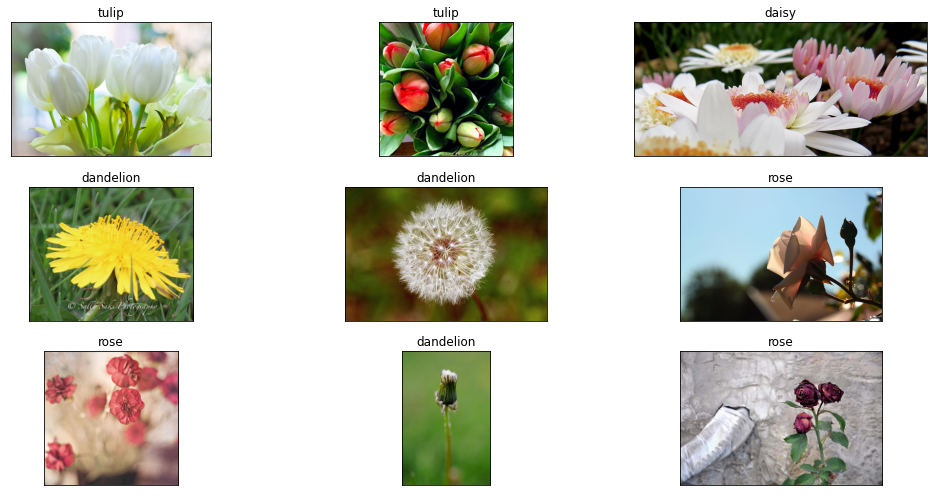

In [37]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df_sample.Filepath[i]))
    ax.set_title(image_df_sample.Label[i])
plt.tight_layout()
plt.show()

In [38]:
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

In [39]:
imagePaths = list(image_df_sample['Filepath'])
rawImages = []
labels = []

In [40]:
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = [image_df_sample['Label'][i]]
    pixels = image_to_feature_vector(image)
    rawImages.append(pixels)
    labels.append(label)

In [41]:
rawImages = np.array(rawImages)
labels = np.array(labels)

In [42]:
(X_train, X_test, y_train, y_test) = train_test_split(
    rawImages, labels, test_size=0.20, random_state=42)

In [43]:
# Prepare a One-vs-Rest classifier to be trained using the raw pixel intensities
knn = KNeighborsClassifier(n_neighbors=1)
classifier = OneVsRestClassifier(knn, n_jobs=-1)
classifier.fit(X_train,y_train)
acc = classifier.score(X_test, np.array(y_test))
print("Raw pixel accuracy: {:.2f}%".format(acc * 100))

Raw pixel accuracy: 86.94%


In [44]:
pred = classifier.predict(X_test)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.90      0.85      0.88       306
   dandelion       0.74      0.95      0.83       431
        rose       0.91      0.84      0.87       296
   sunflower       0.98      0.82      0.89       316
       tulip       0.93      0.86      0.89       381

    accuracy                           0.87      1730
   macro avg       0.89      0.86      0.87      1730
weighted avg       0.88      0.87      0.87      1730



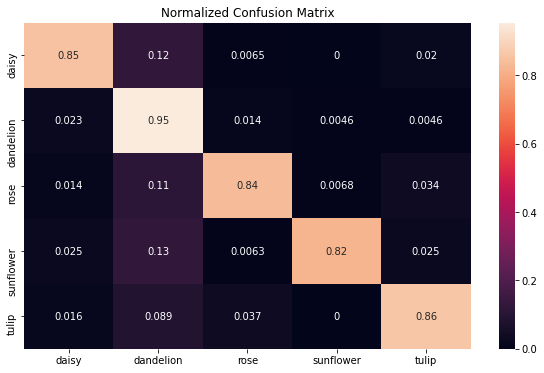

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test.flatten())), yticklabels = sorted(set(y_test.flatten())))
plt.title('Normalized Confusion Matrix')
plt.show()

## 4. Aplicando a Rede Neural MobileNet v2 ao dataset "flowers-recognition"

In [18]:
image_dir = Path('dataset/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,dataset/flowers-recognition/flowers/daisy/1000...,daisy
1,dataset/flowers-recognition/flowers/daisy/1014...,daisy
2,dataset/flowers-recognition/flowers/daisy/1017...,daisy
3,dataset/flowers-recognition/flowers/daisy/1017...,daisy
4,dataset/flowers-recognition/flowers/daisy/1017...,daisy
...,...,...
8641,dataset/flowers-recognition/flowers/tulip/9831...,tulip
8642,dataset/flowers-recognition/flowers/tulip/9870...,tulip
8643,dataset/flowers-recognition/flowers/tulip/9947...,tulip
8644,dataset/flowers-recognition/flowers/tulip/9947...,tulip


In [19]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/flowers-recognition/flowers/tulip/6187...,tulip
1,dataset/flowers-recognition/flowers/flowers/tu...,tulip
2,dataset/flowers-recognition/flowers/daisy/1863...,daisy


In [20]:
import cv2

In [21]:
# Resize and change color of database images using the OpenCV library
IMG_SIZE = 224
resized = []
for path in image_df['Filepath']:
    img_arr = cv2.imread(path, cv2.IMREAD_COLOR)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    resized.append([resized_arr])

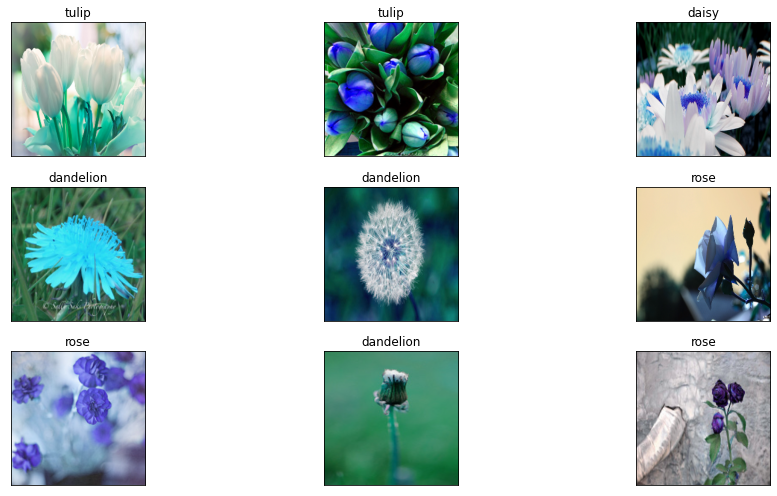

In [22]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(resized[i][0])
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [23]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [24]:
# Using MobileNet v2 Network, from Keras API, create the ImageDataGenerator structures
# that will be responsible for preprocessing the images for the network while
# splitting the database in Train/Test in a 80/20 proportion

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [25]:
# Generate Train subset while setting some parameters 
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
# Generate Validation subset while setting some parameters
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
# Generate Test subset while setting some parameters
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5533 validated image filenames belonging to 5 classes.
Found 1383 validated image filenames belonging to 5 classes.
Found 1730 validated image filenames belonging to 5 classes.


In [26]:
# Load MobileNet v2 model, pretrained on ImageNet dataset
# This is a transfer learning being performed to classify the flower dataset

# Here, it's important to evaluate the parameters being used:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), # image size (224x224) and layers (Red, Green and Blue colors)
    include_top=False,
    weights='imagenet', # call 'imagenet' pretrained weights
    pooling='avg' 
)

# Here, the value False informs that the weights from 'imagenet' shall not be updated
pretrained_model.trainable = False 

In [27]:
# 'inputs' receive the pretrained_model inputs, from TensorFlow
inputs = pretrained_model.input

# The output of the pretrained model is fed to two Dense layers using ReLu activation
# and assigned to 'x'
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# 'x' is fed to a Dense layer with Softmax activation
# and assigned to 'outputs'
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # 5 is the number of labels

# Here, the new model, based on the MobileNet v2, is finally set
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 'history' is the variable used to store the result of the model training process
# The important pieces to be evaluated here are the number of epochs, set as 50,
# and the usage of the EarlyStopping method, used to stop the learning process
# before the end of epochs if a possible overfitting is detected
# This is done by evaluating the 'val_loss' and the 'patience' variables
# If 'val_loss' raises by 'patience' epochs, the learning stops and
# the best weights are restored
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
173/173 [==============================] - 159s 900ms/step - loss: 0.6680 - accuracy: 0.7444 - val_loss: 0.2855 - val_accuracy: 0.9140
Epoch 2/50
173/173 [==============================] - 126s 726ms/step - loss: 0.1963 - accuracy: 0.9357 - val_loss: 0.2424 - val_accuracy: 0.9205
Epoch 3/50
173/173 [==============================] - 125s 723ms/step - loss: 0.1041 - accuracy: 0.9665 - val_loss: 0.2665 - val_accuracy: 0.9306
Epoch 4/50
173/173 [==============================] - 121s 699ms/step - loss: 0.0568 - accuracy: 0.9842 - val_loss: 0.2180 - val_accuracy: 0.9501
Epoch 5/50
173/173 [==============================] - 119s 686ms/step - loss: 0.0330 - accuracy: 0.9933 - val_loss: 0.2162 - val_accuracy: 0.9472
Epoch 6/50
173/173 [==============================] - 121s 698ms/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.1968 - val_accuracy: 0.9588
Epoch 7/50
173/173 [==============================] - 119s 691ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.1927 -

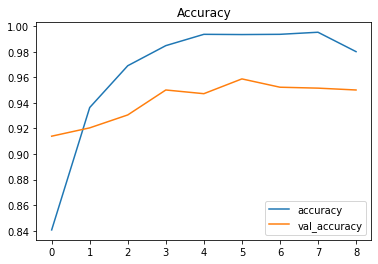

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

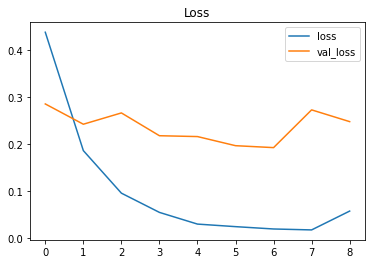

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19836
Test Accuracy: 95.09%


In [31]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['dandelion', 'rose', 'tulip', 'tulip', 'sunflower']


In [32]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.96      0.97      0.97       296
   dandelion       0.99      0.97      0.98       427
        rose       0.88      0.96      0.92       297
   sunflower       0.93      0.97      0.95       298
       tulip       0.98      0.89      0.94       412

    accuracy                           0.95      1730
   macro avg       0.95      0.95      0.95      1730
weighted avg       0.95      0.95      0.95      1730



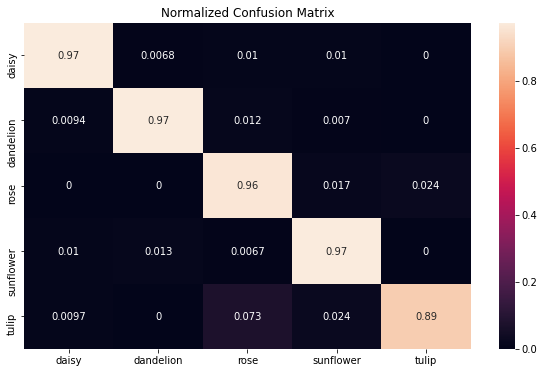

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## 5. Referências

- O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
- Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2016). Densely connected convolutional networks. arXiv preprint arXiv:1608.06993.
- Huang, G., Sun, Y., Liu, Z., Sedra, D., & Weinberger, K. Q. (2016). Deep networks with stochastic depth. In European Conference on Computer Vision (ECCV '16)
- https://www.kaggle.com/alxmamaev/flowers-recognition - Alexander Mamaev
- https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification
- https://www.pyimagesearch.com/2016/08/15/how-to-tune-hyperparameters-with-python-and-scikit-learn/
- https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification